Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 1.951806 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.77e-02, 8.20e-03, 6.17e-01, 2.00e-03, 1.65e-02, 8.17e-01]    [1.59e-02, 8.20e-03, 6.17e-01, 2.00e-03, 1.65e-02, 8.17e-01]    []  
1000      [1.56e-03, 1.51e-04, 5.48e-03, 4.02e-03, 4.18e-04, 9.76e-03]    [1.28e-03, 1.51e-04, 5.48e-03, 4.02e-03, 4.18e-04, 9.76e-03]    []  
2000      [5.15e-03, 3.47e-04, 2.95e-03, 1.00e-03, 1.13e-04, 1.75e-02]    [4.80e-03, 3.47e-04, 2.95e-03, 1.00e-03, 1.13e-04, 1.75e-02]    []  
3000      [1.26e-03, 5.99e-05, 1.37e-03, 5.11e-04, 2.05e-05, 3.75e-03]    [8.21e-04, 5.99e-05, 1.37e-03, 5.11e-04, 2.05e-05, 3.75e-03]    []  
4000      [9.46e-04, 9.85e-05, 1.13e-03, 2.64e-04, 1.65e-05, 2.69e-03]    [5.68e-04, 9.85e-05, 1.13e-03, 2.64e-04, 1.65e-05, 2.69e-03]    []  
5000      [3.52e-03, 1.54e-04, 9.89e-04, 1.05e-04, 7.61e-06, 2.30e-03]

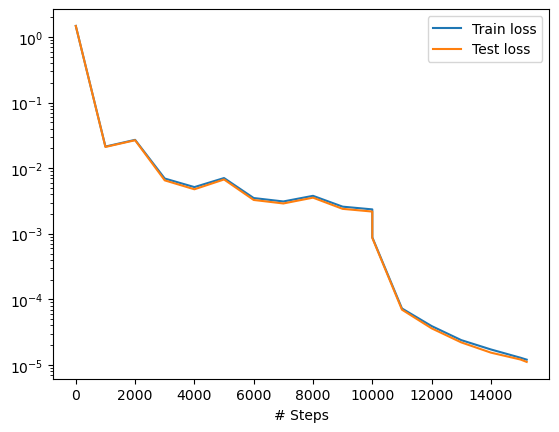

In [1]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf

# Quelques fonctions utiles
t1 = 0
t2 = 1
end_time = 1

# Définition de l'équation différentielle partielle (PDE)
def pde(X, T):
    # Calcul des dérivées secondes de T par rapport à x et y
    dT_xx = dde.grad.hessian(T, X ,j=0)
    dT_yy = dde.grad.hessian(T, X, j=1)
    # Calcul de la dérivée première de T par rapport au temps
    dT_t = dde.grad.jacobian(T, X, j=2)
    
    rhoc = 1
    kap = 1
    # Aucune fonction de forçage n'est ajoutée ici
    return ((rhoc * dT_t) - (kap * (dT_xx + dT_yy)))

# Définition des conditions aux limites pour chaque côté du rectangle
def r_boundary(X, on_boundary):
    x, y, t = X
    return on_boundary and np.isclose(x, 1)

def l_boundary(X, on_boundary):
    x, y, t = X
    return on_boundary and np.isclose(x, 0)

def up_boundary(X, on_boundary):
    x, y, t = X
    return on_boundary and np.isclose(y, 1)

def down_boundary(X, on_boundary):
    x, y, t = X
    return on_boundary and np.isclose(y, 0)

# Définition de la condition initiale au temps t=0
def boundary_initial(X, on_initial):
    x, y, t = X
    return on_initial and np.isclose(t, 0)

# Fonction définissant les conditions initiales
def init_func(X):
    x = X[:, 0:1]
    y = X[:, 1:2]
    t = np.zeros((len(X), 1))
    for count, x_ in enumerate(x):
        if x_ < 0.5:
            t[count] = t1
        else:
            t[count] = t1 + (2) * (x_ - 0.5)
    return t

# Fonctions définissant les conditions de Dirichlet sur les bords gauche et droit
def dir_func_l(X):
    return t1 * np.ones((len(X), 1))

def dir_func_r(X):
    return t2 * np.ones((len(X), 1))

# Fonction retournant un vecteur de zéros pour la condition de Neumann
def func_zero(X):
    return np.zeros((len(X), 1))

# Paramètres de la formation des données
num_domain = 3000
num_boundary = 80
num_initial = 200

# Architecture du réseau de neurones
layer_size = [3] + [32] * 4 + [1]
activation_func = "tanh"
initializer = "Glorot uniform"
lr = 1e-3

# Application des poids de perte pour chaque terme de la fonction de perte
# [PDE Loss, BC1 perte - Dirichlet à gauche, BC2 perte - Dirichlet à droite, BC3 perte - Neumann en haut, BC4 perte - Neumann en bas, IC perte]
loss_weights = [10, 1, 1, 1, 1, 10]

epochs = 10000
optimizer = "adam"
batch_size_ = 256

# Définition de la géométrie spatiale et temporelle du domaine
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Conditions aux limites de Dirichlet et Neumann
bc_l = dde.DirichletBC(geomtime, dir_func_l, l_boundary)
bc_r = dde.DirichletBC(geomtime, dir_func_r, r_boundary)
bc_up = dde.NeumannBC(geomtime, func_zero, up_boundary)
bc_low = dde.NeumannBC(geomtime, func_zero, down_boundary)

# Condition initiale
ic = dde.IC(geomtime, init_func, boundary_initial)

# Création de l'ensemble de données pour l'entraînement
data = dde.data.TimePDE(
    geomtime, pde, [bc_l, bc_r, bc_up, bc_low, ic], 
    num_domain=num_domain, num_boundary=num_boundary, num_initial=num_initial, num_test=num_domain
)

# Définition du modèle basé sur un réseau de neurones entièrement connecté (FNN)
net = dde.maps.FNN(layer_size, activation_func, initializer)

# Application d'une transformation à la sortie du réseau pour garantir que la solution soit positive
net.apply_output_transform(lambda x, y: abs(y))

# Initialisation du modèle avec les données et le réseau défini
model = dde.Model(data, net)

# Compilation du modèle avec l'optimiseur Adam et la fonction de perte pondérée
model.compile(optimizer, lr=lr, loss_weights=loss_weights)

# Sauvegarde du meilleur modèle tous les 1000 epochs
checker = dde.callbacks.ModelCheckpoint(
    "model/model1.ckpt", save_better_only=True, period=1000
)

# Entraînement du modèle
losshistory, trainstate = model.train(epochs=epochs, batch_size=batch_size_)

# Ré-optimisation du modèle avec l'optimiseur L-BFGS-B pour améliorer la convergence
model.compile("L-BFGS-B")
dde.optimizers.set_LBFGS_options(maxcor=50)
losshistory, train_state = model.train(epochs=epochs, batch_size=batch_size_)

# Sauvegarde et affichage des courbes de perte
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)


MovieWriter imagemagick unavailable; using Pillow instead.


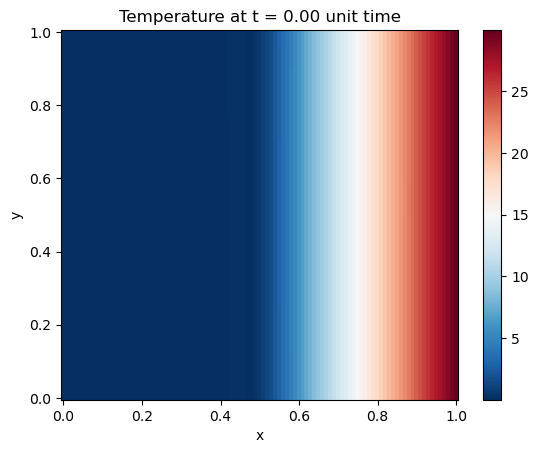

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Parameters
nelx = 100
nely = 100
timesteps = 101
x = np.linspace(0, 1, nelx + 1)
y = np.linspace(0, 1, nely + 1)
t = np.linspace(0, 1, timesteps)
delta_t = t[1] - t[0]
xx, yy = np.meshgrid(x, y)

# Prepare data
x_ = np.zeros((nelx + 1) * (nely + 1),)
y_ = np.zeros((nelx + 1) * (nely + 1),)
for c1, ycor in enumerate(y):
    for c2, xcor in enumerate(x):
        x_[c1 * (nelx + 1) + c2] = xcor
        y_[c1 * (nelx + 1) + c2] = ycor

Ts = []

for time in t:
    t_ = np.ones((nelx + 1) * (nely + 1),) * time
    X = np.column_stack((x_, y_))
    X = np.column_stack((X, t_))
    T = model.predict(X)
    T = T * 30
    T = T.reshape(nelx + 1, nely + 1)
    Ts.append(T)

def plotheatmap(T, time):
    plt.clf()
    plt.title(f"Temperature at t = {time * delta_t:.2f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.pcolor(xx, yy, T, cmap='RdBu_r', shading='auto')
    plt.colorbar()

def animate(k):
    plotheatmap(Ts[k], k)

# Initialize figure
fig = plt.figure()

# Create animation
anim = animation.FuncAnimation(fig, animate, interval=100, frames=len(t), repeat=False)

# Save animation
anim.save("trial1.gif", writer='imagemagick')
